<a href="https://colab.research.google.com/github/chhendley/chhendley_python_projects/blob/main/cancer_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
regions_list = ['Northeast', 'Midwest', 'South', 'West']
print('Please pick a region from the follow list Regions: Northeast, Midwest, South, West')
user_input = input('Enter region to forecast ')
while True:


  if user_input in regions_list:
    region = user_input
    break
  else:
    print('Please enter a valid abbreviaiton from list provided above')
    user_input = input('Enter abbreviation of region to forecast ')


Please pick a region from the follow list Regions: Northeast, Midwest, South, West
Enter region to forecast South


In [2]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 57.8 MB/s eta 0:00:00


In [3]:
import io
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pmdarima as pm
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest
from datetime import datetime, timedelta
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy import stats

In [37]:
url = 'https://github.com/chhendley/chhendley_python_projects/raw/main/United%20States%20and%20Puerto%20Rico%20Cancer%20Statistics%2C%201999-2019%20Incidence.txt'
US_cancer_df = pd.read_table(url, delimiter=' ')

In [38]:
cancer_regions = ['Northeast', 'Midwest', 'South', 'West']
cancer_year = [1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019]
cancer_remove_text = 'Combined"\t"0"\t"Northeast"\t"CENS-R1"\t"1999"\t"1999"\t'
cancer_columns = ['Notes', 'Cancer', 'Sites','Year', 'Actual', 'Region']

In [39]:
US_cancer_df.columns = cancer_columns

In [40]:
for i in range(0,21):
  US_cancer_df.loc[i,"Region"]='Northeast'

for i in range(21,42):
  US_cancer_df.loc[i,"Region"]='Midwest'

for i in range(42,63):
  US_cancer_df.loc[i,"Region"]='South'

for i in range(62,84):
  US_cancer_df.loc[i,"Region"]='West'


In [41]:
NE = 0
MW = 21
S = 42
W = 63
for i in range(1999,2020):
  US_cancer_df.loc[NE, "Year"] = str(i)
  US_cancer_df.loc[MW, "Year"] = str(i)
  US_cancer_df.loc[S, "Year"] = str(i)
  US_cancer_df.loc[W, "Year"] = str(i)
  NE= NE+1
  MW = MW+1
  S = S+1
  W = W+1

In [42]:
US_cancer_df.drop([84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119], inplace=True)


In [43]:
US_cancer_df["Actual"] = US_cancer_df["Actual"].str.slice(start=-6)
US_cancer_df['Actual'] = pd.to_numeric(US_cancer_df["Actual"], downcast="integer")
display(US_cancer_df)


,Notes,Cancer,Sites,Year,Actual,Region
0,"\t""All",Invasive,Cancer,1999,285486,Northeast
1,"\t""All",Invasive,Cancer,2000,291637,Northeast
2,"\t""All",Invasive,Cancer,2001,300174,Northeast
3,"\t""All",Invasive,Cancer,2002,301577,Northeast
4,"\t""All",Invasive,Cancer,2003,297996,Northeast
...,...,...,...,...,...,...
79,"\t""All",Invasive,Cancer,2015,345441,West
80,"\t""All",Invasive,Cancer,2016,351117,West
81,"\t""All",Invasive,Cancer,2017,358696,West
82,"\t""All",Invasive,Cancer,2018,345308,West


In [44]:
#cancer dataframe cleaning function
def total_sum(df):
  df.loc['Total']= df.sum()
  df.at['Total', 'Notes'] = ''
  df.at['Total', 'Cancer'] = ''
  df.at['Total', 'Sites'] = ''
  df.at['Total', 'Year'] = ''
  df.at['Total', 'Region'] = ''
  return df

In [45]:
NE_cancer = US_cancer_df[US_cancer_df['Region'] == 'Northeast']
MW_cancer = US_cancer_df[US_cancer_df['Region'] == 'Midwest']
S_cancer = US_cancer_df[US_cancer_df['Region'] == 'South']
W_cancer = US_cancer_df[US_cancer_df['Region'] == 'West']

In [46]:
US_cancer_df = total_sum(US_cancer_df)
US_cancer_df.drop(['Notes', 'Cancer', 'Sites'], axis=1, inplace=True)
NE_cancer_df = total_sum(NE_cancer)
MW_cancer_df = total_sum(MW_cancer)
S_cancer_df = total_sum(S_cancer)
W_cancer_df = total_sum(W_cancer)


In [47]:
#sugar dataframe cleaning helper function
def clean_data(col_name, link):
  data = pd.read_excel(str(link))
  data.drop([0,1,2,3,4,5,6], inplace=True)
  data.fillna(0)
  data.astype(int)
  data.columns = col_name
  #data['DATE'] = pd.to_datetime(data[['Year', 'Month']].assign(DAY=1))
  data['DATE'] = pd.to_datetime(data[['Year', 'Month' ]].assign(DAY=1), format='%Y-%m-%d')
  #data.reset_index(inplace=True)
  data.set_index(data['DATE'], inplace=True)
  data.loc['Total']= data.sum()
  data.at['Total', 'DATE'] = '0'
  #data.drop(data.columns[[0,1,-1]],axis=1,inplace=True)
  data.drop(['DATE', 'Year', 'Month'],axis=1,inplace=True)
  return data


def clean_data1(col_name, link):
  data = pd.read_excel(str(link))
  data.drop([0,1,2,3,4, 380], inplace=True)
  data.fillna(0)
  data.astype(int)
  data.columns = col_name
  data['DATE'] = pd.to_datetime(data[['Year', 'Month']].assign(DAY=1))
  #data.reset_index(inplace=True)
  data.set_index(data['DATE'], inplace=True)
  data.loc['Total']= data.sum()
  data.at["Total", 'DATE'] = '0'
  data.drop(['DATE', 'Year', 'Month'],axis=1,inplace=True)
  return data

In [48]:
from keras.layers import BatchNormalization
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import BatchNormalization
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.utils import to_categorical
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import numpy as np

start hybrid model

In [49]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings

In [50]:
test_df = US_cancer_df[US_cancer_df['Region'] == region].copy()
test_df['Date'] = pd.to_datetime(test_df['Year'])

In [51]:
warnings.filterwarnings("ignore")
df = test_df

In [52]:
df['Date'] = pd.to_datetime(df['Year'])
df['Year'] = df['Date'].dt.year

In [53]:
df = df.set_index("Date")

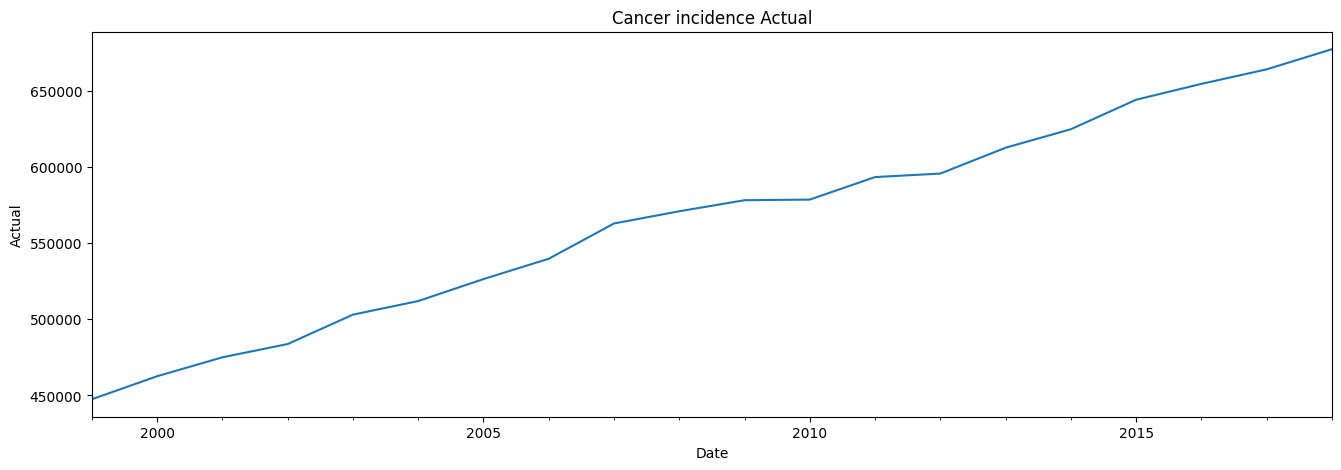

In [54]:
df.index.asfreq = ('Y')
ax = df['Actual'].plot(figsize = (16,5), title = 'Cancer incidence Actual')
ax.set(xlabel='Date', ylabel='Actual');

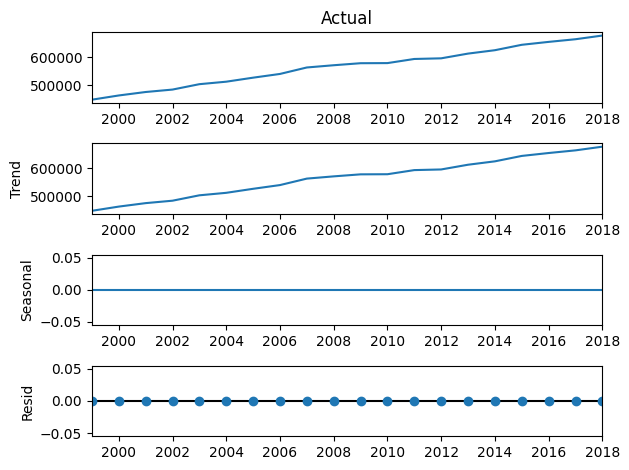

In [55]:
a = seasonal_decompose(df["Actual"], model = "add")
a.plot();

In [56]:
df['Actual'] = df['Actual'].astype('int')
df['Actual'].dtypes

dtype('int64')

In [57]:
split_data = df['Actual'].copy()
train_data = split_data[:len(df)-4]
test_data = split_data[len(df)-4:]
train_data.columns = ['Actual']

In [58]:
arima_model = auto_arima(df['Actual'])
display(arima_model.summary())
arima_result = arima_model.fit(train_data)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   20
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -190.675
Date:                Fri, 16 Jun 2023   AIC                            385.349
Time:                        00:02:47   BIC                            387.238
Sample:                    01-01-1999   HQIC                           385.669
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    1.21e+04   1275.906      9.483      0.000    9598.691    1.46e+04
sigma2       3.05e+07   1.04e+07      2.939      0.003    1.02e+07    5.08e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.99   Jarque-Bera (JB):                 0.10
Prob(Q):                              0.32   Prob(JB):                         0.95
Heteroskedasticity (H):               0.99   Skew:                            -0.16
Prob(H) (two-sided):                  0.99   Kurtosis:                         2.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [59]:
arima_pred = arima_result.predict(n_periods = len(test_data), typ="levels").rename("ARIMA Predictions")


In [60]:
val_data_df = pd.DataFrame(test_data)
val_data_df['ARIMA Predictions'] = arima_pred.values
val_data_df['ARIMA Predictions'].astype('int')
val_data_df.rename(columns= {'Actual':'Actual'})


,Actual,ARIMA Predictions
Date,,
2015-01-01,644209,636649.066667
2016-01-01,654618,648471.133333
2017-01-01,664165,660293.200000
2018-01-01,677385,672115.266667


<Axes: xlabel='Date'>

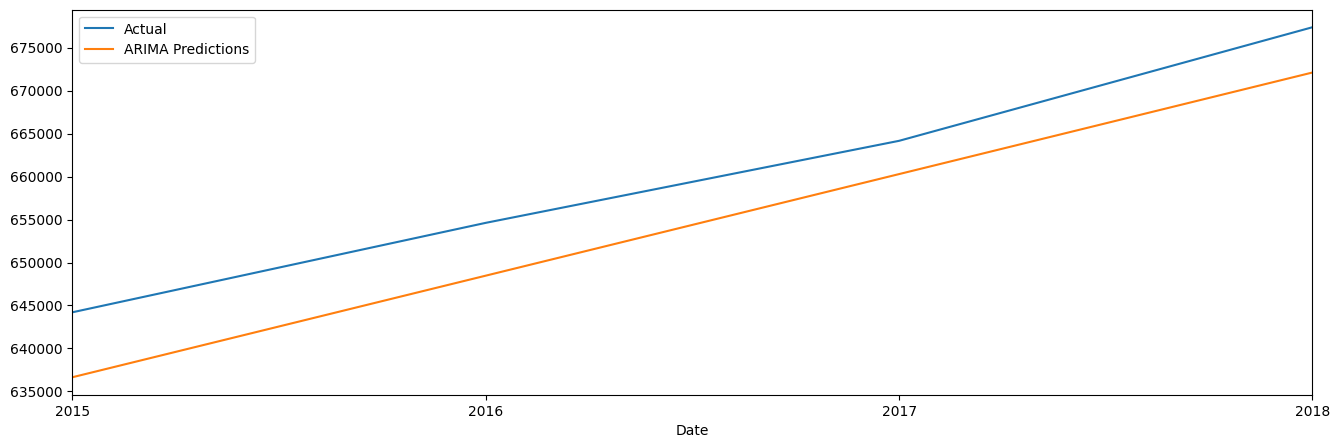

In [61]:
val_data_df.plot(figsize = (16,5), legend=True)
#val_data_df.plot(legend = True);

In [62]:
arima_rmse_error = rmse(test_data, arima_pred)
arima_mse_error = arima_rmse_error**2
mean_value = df.mean()

print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}\nMean: {mean_value}')

MSE Error: 34424371.61666708
RMSE Error: 5867.228614658464
Mean: Year        2008.50
Actual    565389.95
dtype: float64


In [63]:
!pip install fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  Preparing metadata (setup.py) ... done
  Using cached cmdstanpy-0.9.5-py3-none-any.whl (37 kB)
  Using cached pystan-3.7.0-py3-none-any.whl (13 kB)
  Using cached setuptools_git-1.2-py2.py3-none-any.whl (10 kB)
  Using cached aiohttp-3.8.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.0 MB)
  Using cached clikit-0.6.2-py2.py3-none-any.whl (91 kB)
  Using cached httpstan-4.10.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (44.4 MB)
  Using cached pysimdjson-5.0.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.8 MB)
  Using cached multidict-6.0.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (114 kB)
  Using cached async_timeout-4.0.2-py3-none-any.whl (5.8 kB)
  Using cached yarl-1.9.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (268 kB)
  Using cached frozenlist-1.3.3-cp

In [64]:
x = df['Actual'].copy()
display(x)

Date
1999-01-01    447496
2000-01-01    462602
2001-01-01    475030
2002-01-01    483753
2003-01-01    503052
2004-01-01    511978
2005-01-01    526409
2006-01-01    539758
2007-01-01    562932
2008-01-01    570950
2009-01-01    578207
2010-01-01    578619
2011-01-01    593413
2012-01-01    595714
2013-01-01    612682
2014-01-01    624827
2015-01-01    644209
2016-01-01    654618
2017-01-01    664165
2018-01-01    677385
Name: Actual, dtype: int64

In [65]:
df_pr = df['Actual'].copy()
df_pr = df_pr.reset_index()

df_pr.columns = ['ds','y'] # To use prophet column names should be like that
display(df_pr)
train_data_pr = df_pr.iloc[:len(df)-4]
test_data_pr = df_pr.iloc[len(df)-4:]
from prophet import Prophet
m = Prophet()
m.fit(train_data_pr)
future = m.make_future_dataframe(periods=4,freq='Y')
prophet_pred = m.predict(future)
prophet_pred.tail()

,ds,y
0,1999-01-01,447496
1,2000-01-01,462602
2,2001-01-01,475030
3,2002-01-01,483753
4,2003-01-01,503052
5,2004-01-01,511978
6,2005-01-01,526409
7,2006-01-01,539758
8,2007-01-01,562932
9,2008-01-01,570950


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz6f2g_wk/2rw079md.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz6f2g_wk/88pfiffp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25081', 'data', 'file=/tmp/tmpz6f2g_wk/2rw079md.json', 'init=/tmp/tmpz6f2g_wk/88pfiffp.json', 'output', 'file=/tmp/tmpz6f2g_wk/prophet_model_qx681ny/prophet_model-20230616000258.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
00:02:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:02:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
15,2014-01-01,189742.316608,616143.053306,625542.290449,189742.316608,189742.316608,431051.439426,431051.439426,431051.439426,431051.439426,431051.439426,431051.439426,0.0,0.0,0.0,620793.756034
16,2014-12-31,198780.177401,622513.351639,632283.598003,198525.510957,199057.066101,428881.586124,428881.586124,428881.586124,428881.586124,428881.586124,428881.586124,0.0,0.0,0.0,627661.763525
17,2015-12-31,207842.867481,630973.358260,640199.346825,206947.175165,208721.030223,427695.772192,427695.772192,427695.772192,427695.772192,427695.772192,427695.772192,0.0,0.0,0.0,635538.639674
18,2016-12-31,216930.386849,642075.471902,652629.690461,215022.652690,218723.856910,430455.119700,430455.119700,430455.119700,430455.119700,430455.119700,430455.119700,0.0,0.0,0.0,647385.506549
19,2017-12-31,225993.076930,649991.228660,661341.834735,222869.358332,228786.706774,429796.328389,429796.328389,429796.328389,429796.328389,429796.328389,429796.328389,0.0,0.0,0.0,655789.405319


In [66]:
prophet_pred = pd.DataFrame({"Date" : prophet_pred[-4:]['ds'], "Pred" : prophet_pred[-4:]["yhat"]})
prophet_pred = prophet_pred.set_index("Date")
prophet_pred.index.freq = "Y"
prophet_pred

,Pred
Date,
2014-12-31,627661.763525
2015-12-31,635538.639674
2016-12-31,647385.506549
2017-12-31,655789.405319


In [67]:
val_data_df["Prophet Predictions"] = prophet_pred['Pred'].values
display(val_data_df)

,Actual,ARIMA Predictions,Prophet Predictions
Date,,,
2015-01-01,644209,636649.066667,627661.763525
2016-01-01,654618,648471.133333,635538.639674
2017-01-01,664165,660293.200000,647385.506549
2018-01-01,677385,672115.266667,655789.405319


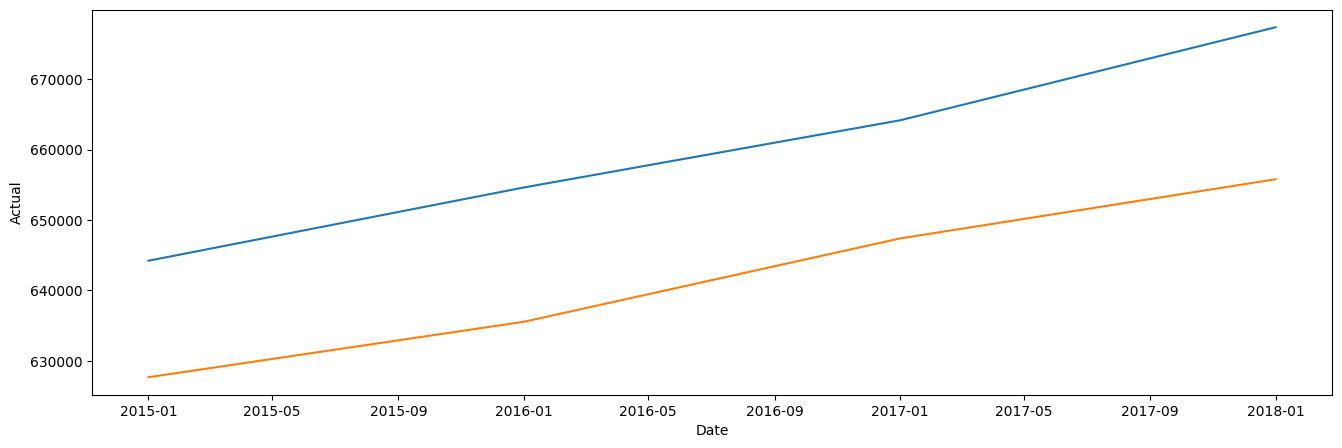

In [74]:
#val_data_df["Prophet_Predictions"] = prophet_pred['Pred'].values
import seaborn as sns
plt.figure(figsize=(16,5))
ax = sns.lineplot(x= val_data_df.index, y=val_data_df['Actual'])
sns.lineplot(x=val_data_df.index, y = val_data_df["Prophet Predictions"], legend=True);

In [69]:
prophet_rmse_error = rmse(val_data_df['Actual'], val_data_df["Prophet Predictions"])
prophet_mse_error = prophet_rmse_error**2
mean_value = df['Actual'].mean()

print(f'MSE Error: {prophet_mse_error}\nRMSE Error: {prophet_rmse_error}\nMean: {mean_value}')

MSE Error: 346438533.8841187
RMSE Error: 18612.859368837413
Mean: 565389.95


In [70]:
display(val_data_df.columns)

Index(['Actual', 'ARIMA Predictions', 'Prophet Predictions'], dtype='object')

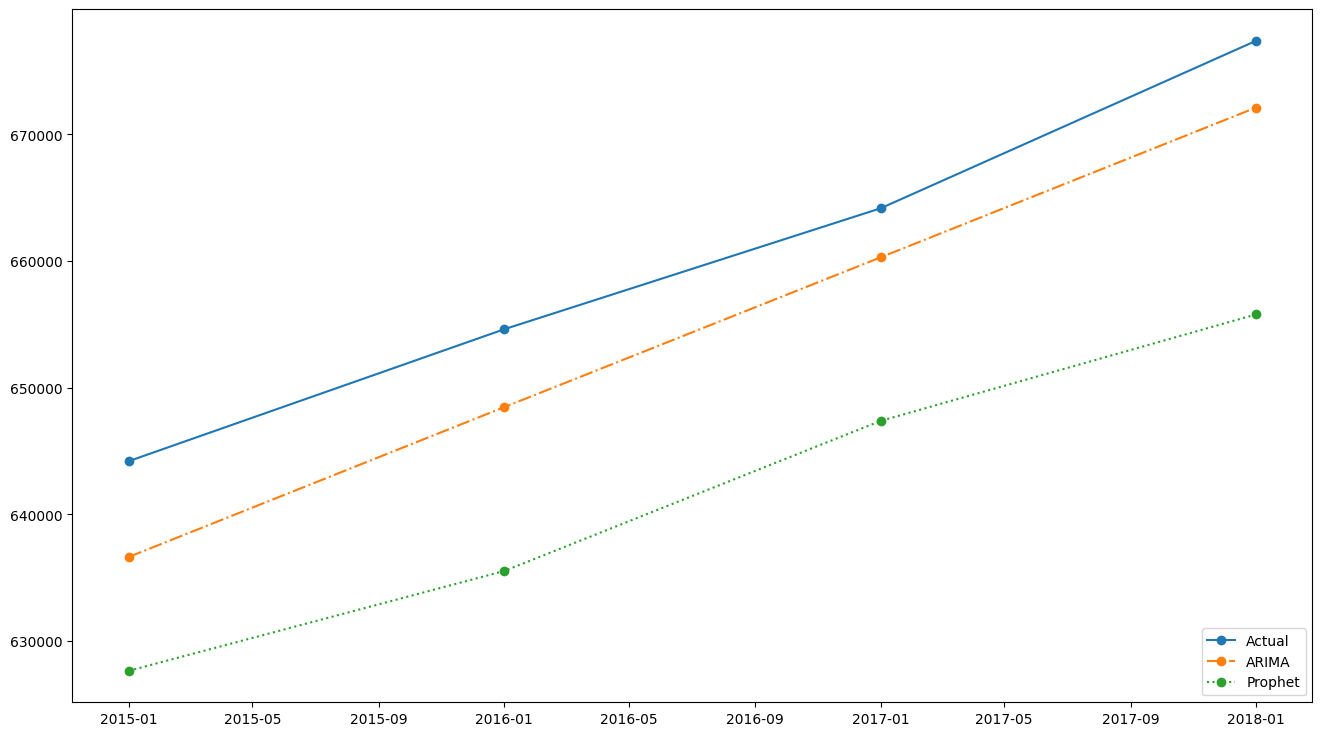

In [71]:
rmse_errors = [arima_rmse_error, prophet_rmse_error]
mse_errors = [arima_mse_error, prophet_mse_error]
errors = pd.DataFrame({"Models" : ["ARIMA", "Prophet"],"RMSE Errors" : rmse_errors, "MSE Errors" : mse_errors})
plt.figure(figsize=(16,9))
plt.plot_date(val_data_df.index, val_data_df['Actual'], linestyle="-")
plt.plot_date(val_data_df.index, val_data_df["ARIMA Predictions"], linestyle="-.")
plt.plot_date(val_data_df.index, val_data_df["Prophet Predictions"], linestyle=":")
plt.legend(["Actual", "ARIMA", 'Prophet'], loc ="lower right")
plt.show()

In [72]:
print(f"Mean: {val_data_df['Actual'].mean()}")
errors

Mean: 660094.25


,Models,RMSE Errors,MSE Errors
0,ARIMA,5867.228615,3.442437e+07
1,Prophet,18612.859369,3.464385e+08


In [73]:
val_data_df

,Actual,ARIMA Predictions,Prophet Predictions
Date,,,
2015-01-01,644209,636649.066667,627661.763525
2016-01-01,654618,648471.133333,635538.639674
2017-01-01,664165,660293.200000,647385.506549
2018-01-01,677385,672115.266667,655789.405319
